In [ ]:
#!pip install backtrader

Starting Portfolio Value: 1000.00
2000-02-18, Close, 26.05
2000-02-18, BUY CREATE, 26.05
2000-02-22, BUY EXECUTED, Price: 26.30, Cost: 263.00, Comm 0.26
2000-02-22, Close, 26.38
2000-02-23, Close, 28.05
2000-02-24, Close, 27.55
2000-02-25, Close, 31.41
2000-02-28, Close, 30.52
2000-02-29, Close, 33.02
2000-03-01, Close, 31.80
2000-03-02, Close, 30.47
2000-03-03, Close, 33.36
2000-03-06, Close, 33.69
2000-03-07, Close, 33.33
2000-03-08, Close, 36.97
2000-03-09, Close, 37.36
2000-03-10, Close, 36.30
2000-03-13, Close, 35.02
2000-03-14, Close, 34.25
2000-03-15, Close, 34.97
2000-03-16, Close, 36.44
2000-03-17, Close, 35.50
2000-03-20, Close, 34.75
2000-03-21, Close, 35.89
2000-03-22, Close, 37.39
2000-03-23, Close, 38.64
2000-03-24, Close, 38.69
2000-03-27, Close, 39.33
2000-03-28, Close, 38.50
2000-03-29, Close, 36.69
2000-03-30, Close, 34.88
2000-03-31, Close, 34.72
2000-04-03, Close, 34.19
2000-04-04, Close, 33.77
2000-04-05, Close, 34.80
2000-04-06, Close, 36.55
2000-04-07, Close, 38.

<IPython.core.display.Javascript object>


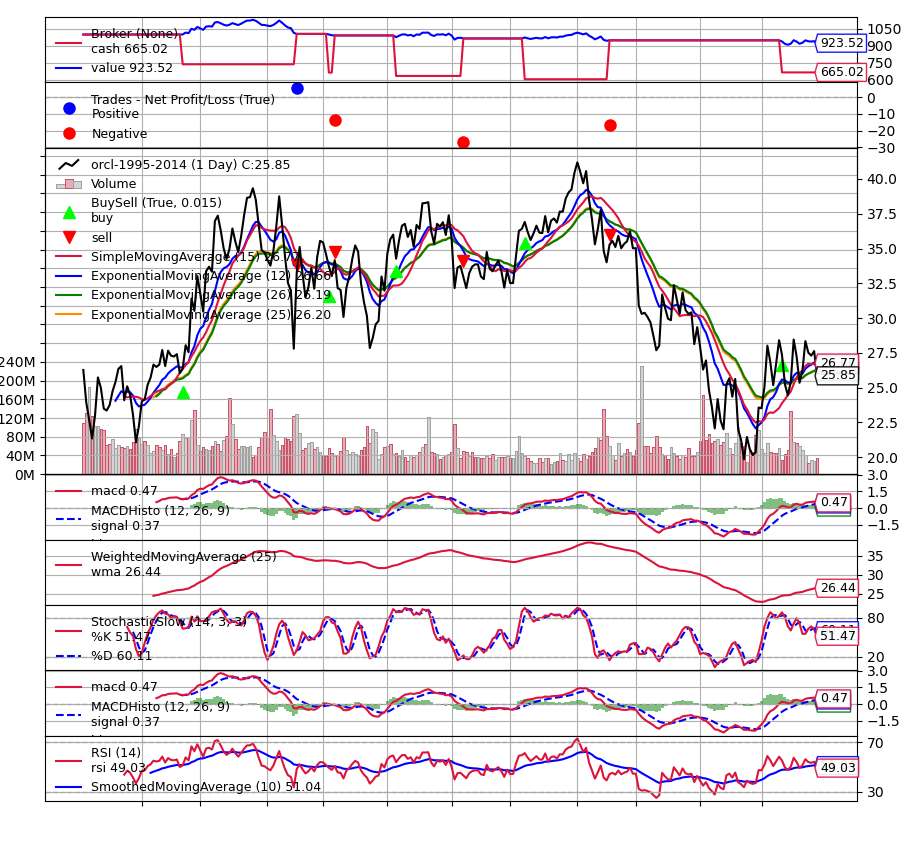

In [29]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import datetime # for datetime objects
import os.path # to manage paths
import sys # to find out the script name

# import the backtrader framework
import backtrader as bt

# Create a Strategy
class TestStrategy(bt.Strategy):
    
    params = (
    ('maperiod',15),
    #('printlog',False)
    )
    
    def log(self,txt,dt = None): #,doprint = False):
        ''' Logging function for this strategy'''
        #if self.params.printlog or doprint:
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        # keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
        self.datas[0], period = self.params.maperiod)
        self.veloacc = bt.indicators.MACDHisto(self.datas[0]) + bt.indicators.ExponentialMovingAverage(self.datas[0], period=12) - bt.indicators.ExponentialMovingAverage(self.datas[0], period=26)
        
        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)
        
    def notify_order(self,order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' % 
                    (order.executed.price,
                    order.executed.value,
                    order.executed.comm))
                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else: 
                self.log('SELL EXECUTED, PRICE: %.2f, Cost: %.2f, Comm %.2f' % 
                         (order.executed.price,
                         order.executed.value,
                         order.executed.comm))
                
            self.bar_executed = len(self)
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                (trade.pnl, trade.pnlcomm))
    
    def next(self):
        # simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        # Check if an order is pending... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        # Check if we are in the market
        if not self.position:
        
            if self.veloacc[0] > 0:
            #if self.dataclose[0] > self.sma[0]:
                # if current close less than the previous close

                # BUY BUY BUY!!! 
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
        
        else:
            
            if self.veloacc[0] < 0:
                # SELL, SELL, SELL!!! 
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                
                # keep track of the created order to avoid a 2nd order
                self.order = self.sell()
        
#     def stop(self):
#         self.log('(MA Period %2d) Ending Value %.2f' %
#                  (self.params.maperiod, self.broker.getvalue()), doprint=True)
        
if __name__ == '__main__':
    # create a Cerebro engine instance
    cerebro = bt.Cerebro()
    
    # add a strategy
    cerebro.addstrategy(TestStrategy)
    #strats = cerebro.optstrategy(
    #TestStrategy,
    #maperiod = range(10,31))
    
    # data is in a subfolder of samples. Need to find where the script is because it could have been called from anywhere.
    # This is tutorial data and I chose to clone the github repo within the current directory
    modpath = os.path.abspath(os.path.curdir)
    datapath = os.path.join(modpath, 'backtrader\\datas\\orcl-1995-2014.txt')
    
    # create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
    dataname = datapath,
    # Don't pass values before this date!
    fromdate = datetime.datetime(2000,1,1),
    # Don't pass values after this date!
    todate = datetime.datetime(2000,12,31),
    reverse = False)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)
    
    # set our desired cash start
    cerebro.broker.setcash(1000.0)
    
    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake = 10)
    
    # set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    # run over everything
    cerebro.run()
    
    # print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.plot()